# TODO:
1. Run comment sentimentality analysis on comments to give them a score.
        1. Average sentimentality score (how to weigh comments?) DONE.
        2. Max/min/median score        DONE.
        3. Score by user (harder)
        4. Aggregate score of novels DONE.
        5. Sitewide score
2. Figure out how to attach all of the comment data to their respective chapters.
        Does the dataframe contain another dataframe? 
        Or do I do something in PostgreSQL to refer to other tables?
        
        DONE.  
                Figure out how to get Postgres GROUP BY to work. Or only use PostgreSQL DB for storage.
3. Write data to database
        DONE.
                Need to figure out how I want to structure the data writing:
                    Per novel basis?
                    Run the data extraction once a day and write it all at once?
                    Data only updated upon request?
                    
4. Exploratory data analysis/visualization
5. Create website to put visualizations on. A GUI to switch between graphs of various novels

# Importing Libraries

In [3]:
import requests
import json
import pandas as pd
import datetime
import math


# Pulling Novel Data and Cleaning

In [5]:
def pullNovelData(novelURL):
    a,b,c,d,novel = novelURL.split('/')
    novel_data = json.loads(requests.get("https://www.wuxiaworld.com/api/novels/details/{}".format(novel)).text)
    novel_len = len(novel_data['item']['chapterGroups'])
    novel_df = pd.DataFrame()
    for i in range(novel_len):
        temp_df = pd.DataFrame(novel_data['item']['chapterGroups'][i]['chapters'])
        frames = [novel_df, temp_df]
        novel_df = pd.concat(frames)
    del novel_df['isTeaser']
    novel_df.set_index('number',inplace=True)
    novel_df['whenToPublish'] = pd.to_datetime(novel_df['whenToPublish'],unit='s')
    #Save as CSV
    #novel_df.to_csv('{} chapters.csv'.format(novel))
    
    return novel_df

In [12]:
#pullNovelData('https://www.wuxiaworld.com/novel/a-will-eternal')

In [4]:
#with open('response.txt', 'w') as outfile:  
#    json.dump(response, outfile)

In [5]:
##print(json.dumps(response, indent=4, sort_keys=True))

# Pulling Chapter Comment Data and Cleaning

In [151]:
def pullComments(id):
    json_comments = json.loads(requests.get("https://www.wuxiaworld.com/api/comments/{}/top".format(id)).text)
    pages = math.ceil(json_comments['totalTopLevel']/25)
    comments = []
    for i in range(pages):
        page = i + 1
        append = json.loads(requests.get("https://www.wuxiaworld.com/api/comments/{}/top?page={}".format(id,page)).text)
        comments = comments + append['items']
    comments = pd.DataFrame(comments)
    comments['timeCommented'] = pd.to_datetime(comments['timeCommented'],unit='s')
    comments['joinDate'] = pd.to_datetime(comments['joinDate'],unit='s')
    del comments['avatar']
    del comments['approved']
    del comments['deleted']
    # del comments['children'] # ignore children
    return comments ##list of comments
    #return comments ## returns Data Frame of comments

In [7]:
ldk_df = pullNovelData('https://www.wuxiaworld.com/novel/legend-of-the-dragon-king')


In [8]:
test = pullComments(28263).head(5)

In [9]:
test.head()

,children,content,depth,downVotes,edited,flair,id,joinDate,poster,posterId,timeCommented,upVotes,vip
0,"[{'id': 696232, 'content': 'It's all Hu Yuhao'...","yay\n\n\n____________\n\nOoh, i wonder, i wonder.",1,0,False,None,696231,2016-06-30 01:48:38,JoyBoy,8aeed258-7f8a-46d6-b9af-7967fc439fe1,2016-12-01 07:32:59,0,False
1,[],......,1,0,False,None,696234,2015-10-18 10:55:30,Lifeless Fog,0d817a5b-1198-4f3f-a77a-3d9250dda65e,2016-12-01 08:07:14,0,False
2,[],I wonder how this story is going to progress.\...,1,0,False,None,696235,2016-07-02 23:51:10,The Grimm Reaper,27c11ad5-7f38-4cc7-b363-562c7c64802d,2016-12-01 10:41:52,0,False
3,[],I have a good feeling about this! :),1,0,False,None,696236,2016-05-06 01:29:54,Emerald,9ae8d6f8-f117-4eae-9aa1-a21835126ba9,2016-12-01 17:10:41,0,False
4,"[{'id': 696238, 'content': 'I think its Chapte...",Thanks for the chapter! I'm currently reading ...,1,0,False,None,696237,2016-03-21 21:01:16,Soldier419,a2e09084-80d6-468d-ba1e-bcb46e9a1ce5,2016-12-02 03:33:33,0,False


In [10]:
ldk_df.head()

,id,name,slug,spoilerTitle,whenToPublish
number,,,,,
0.0,28263,Prologue,ldk-chapter-0,False,2016-11-27 00:13:34
1.0,28170,Chapter 1 – Awakening Day,ldk-chapter-1,False,2016-11-25 03:27:29
2.0,28171,Chapter 2 – Martial Soul Awakening,ldk-chapter-2,False,2016-11-25 03:33:47
3.0,28172,Chapter 3 – Little Wulin’s Family,ldk-chapter-3,False,2016-11-25 03:36:01
4.0,28173,Chapter 4 – Entering the Academy,ldk-chapter-4,False,2016-11-25 03:38:39


In [11]:
ldk_ids = ldk_df['id'].tolist()
ldk_ch = ldk_df.index.tolist()

In [12]:
def pullAllComments(novelDF):
    rows, columns = novelDF.shape
    novel_ids = novelDF['id'].tolist()
    novel_numbers = novelDF.index.tolist()
    columns = ['children', 'content', 'depth', 'downVotes', 'edited', 'flair', 'id', 'joinDate', 'poster', 'posterId', 'timeCommented', 'upVotes', 'vip','chID','chNumber']
    novel_comments = pd.DataFrame(columns=columns)
    for i in range(rows):
        ch_id = novel_ids[i]
        ch_number = novel_numbers[i]
        ch_comments = pullComments(ch_id)
        ch_comments['chID'] = ch_id
        ch_comments['chNumber'] = ch_number
        novel_comments = pd.concat([novel_comments,ch_comments])
    novel_comments.reset_index(inplace=True)
    return novel_comments
        

In [156]:
test = pullAllComments(ldk_df.head(5))

In [11]:
import time
start_time = time.time()
test = pullAllComments(ldk_df.head(10))

print("--- %s seconds ---" % (time.time() - start_time))

--- 6.476012468338013 seconds ---


In [15]:
#rows, columns = df.shape

In [14]:
#df['id'].iloc[1]

# Calculating Sentimentality

In [1]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

In [68]:
def sentimentScore(sentence):
    snt = analyser.polarity_scores(sentence)
    return snt['compound']

In [69]:
def calcSentScores(data):
    data['sentiment'] = data['content'].apply(sentimentScore)

In [138]:
def chSentScores(data):
    return data.groupby(['chNumber']).mean()

In [137]:
def sentimentStats(data):
    print(data['sentiment'].describe())

In [61]:
ldk_df = pullNovelData('https://www.wuxiaworld.com/novel/legend-of-the-dragon-king')

In [62]:
test = pullAllComments(ldk_df)

In [74]:
calcSentScores(test)
test.drop(['index'],axis=1,inplace=True)

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

In [119]:
sentDF = chSentScores(test)
sentDF.reset_index(inplace=True)

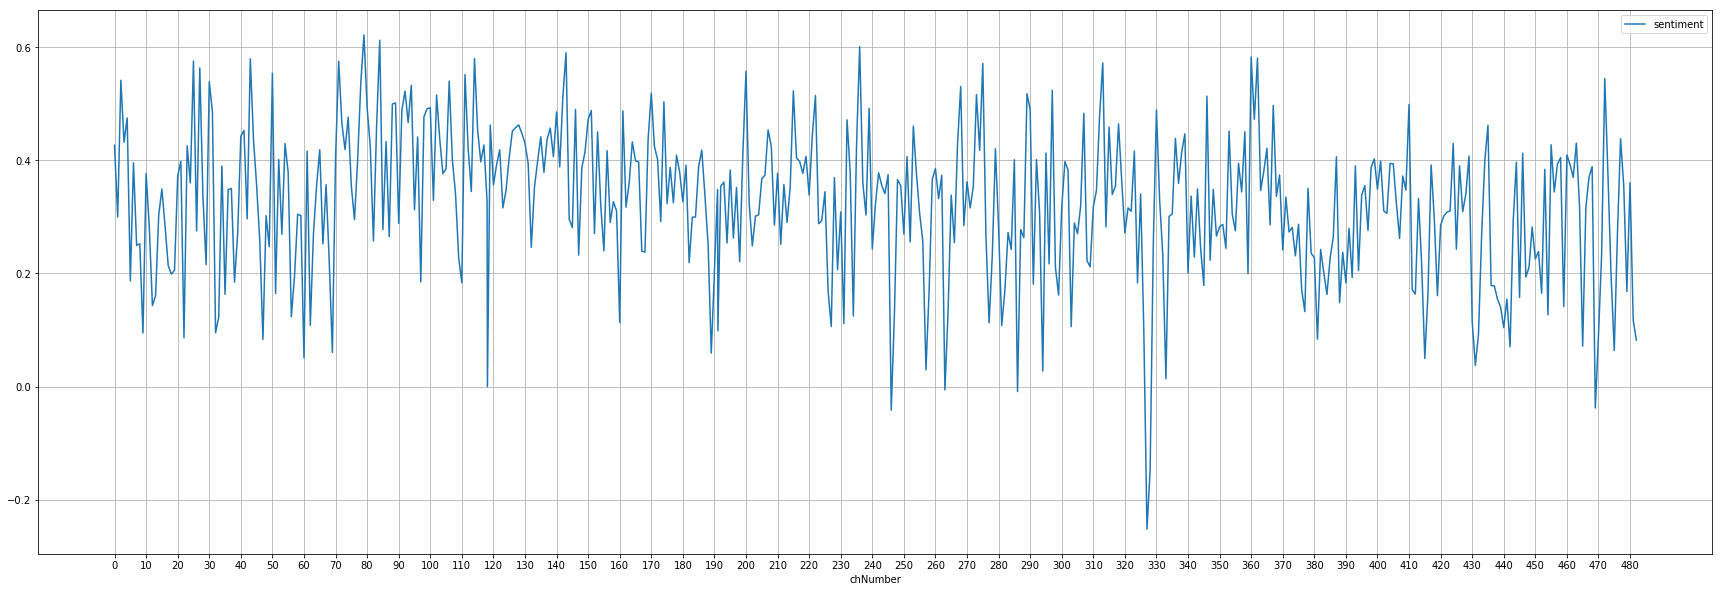

In [148]:
sentDF.plot(x='chNumber', y='sentiment',kind='line', figsize=(30,10),xticks=sentDF[sentDF['chNumber'] % 10 == 0]['chNumber'],grid=True)

# Testing on AWE

In [153]:
awe_df = pullNovelData('https://www.wuxiaworld.com/novel/a-will-eternal')

In [160]:
awe_df.drop([-2.0,-1.0],inplace=True)

In [ ]:
awe_data =  pullAllComments(awe_df)

In [ ]:
calcSentScores(awe_data)
awe_data.drop(['index'],axis=1,inplace=True)

In [ ]:
aweDF = chSentScores(awe_data)
aweDF.reset_index(inplace=True)

In [ ]:
aweDF.plot(x='chNumber', y='sentiment',kind='line', figsize=(60,20),xticks=sentDF[sentDF['chNumber'] % 10 == 0]['chNumber'],grid=True)

In [ ]:
sentimentStats(awe_data)

# Connecting to Database


In [13]:
import psycopg2 as pg
import pandas.io.sql as psql

In [130]:
hostname = 'ww2-db.ctftvmg9rvjb.us-west-1.rds.amazonaws.com'
username = ''
passw = 


conn = pg.connect(host=hostname, user=username, password=passw, dbname='WW2_Comments')
cur = conn.cursor()

SyntaxError: invalid syntax (<ipython-input-130-000cee6570ae>, line 3)

In [13]:
ldk_df = pullNovelData('https://www.wuxiaworld.com/novel/legend-of-the-dragon-king')

In [14]:
import sqlalchemy
from sqlalchemy import create_engine

In [15]:

engine = create_engine('postgresql://:@ww2-db.ctftvmg9rvjb.us-west-1.rds.amazonaws.com:5432/WW2_Comments')

dtype('int64')

In [20]:
test.to_sql('LDK_Comments2', engine, if_exists='replace', dtype = {'children': sqlalchemy.types.JSON})

In [60]:
x = cur.execute('SELECT * FROM "LDK";')
x

In [62]:
cur.fetchall()

[(0.0,
  28263,
  'Prologue',
  'ldk-chapter-0',
  False,
  datetime.datetime(2016, 11, 27, 0, 13, 34)),
 (1.0,
  28170,
  'Chapter 1 – Awakening Day',
  'ldk-chapter-1',
  False,
  datetime.datetime(2016, 11, 25, 3, 27, 29)),
 (2.0,
  28171,
  'Chapter 2 – Martial Soul Awakening',
  'ldk-chapter-2',
  False,
  datetime.datetime(2016, 11, 25, 3, 33, 47)),
 (3.0,
  28172,
  'Chapter 3 – Little Wulin’s Family',
  'ldk-chapter-3',
  False,
  datetime.datetime(2016, 11, 25, 3, 36, 1)),
 (4.0,
  28173,
  'Chapter 4 – Entering the Academy',
  'ldk-chapter-4',
  False,
  datetime.datetime(2016, 11, 25, 3, 38, 39)),
 (5.0,
  28174,
  "Chapter 5 – Na'er",
  'ldk-chapter-5',
  False,
  datetime.datetime(2016, 11, 25, 3, 39, 38)),
 (6.0,
  28179,
  'Chapter 6 – Bringing Her Home',
  'ldk-chapter-6',
  False,
  datetime.datetime(2016, 11, 25, 3, 39, 54)),
 (7.0,
  28175,
  'Chapter 7 – Stay here and be my little sister',
  'ldk-chapter-7',
  False,
  datetime.datetime(2016, 11, 25, 3, 41, 58)),
 (

In [56]:
xdf = pd.DataFrame(cur.fetchall())